In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
# Import libraries

import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from scipy import stats

import my_functions as func

In [4]:
"""
Main program

"""

# Initiate a dictionary with characteristics and layout information
char_dict = func.make_char_dict()

---

## Cylindricity of convex cylinders

---

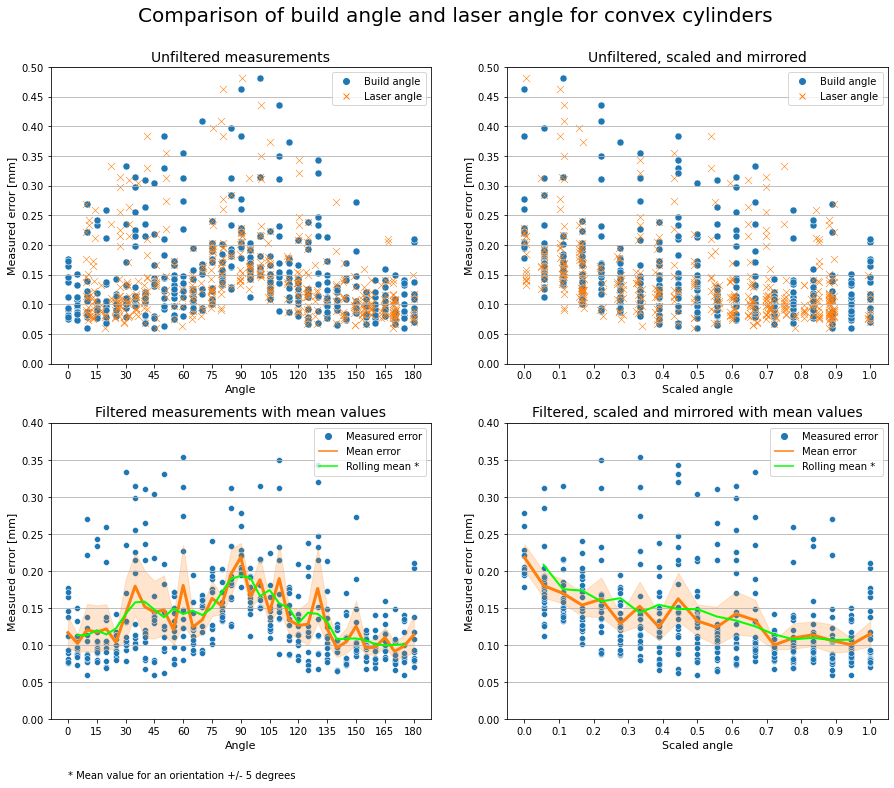

In [5]:
"""
Plot measured error for convex cylinders with respect to orientation.
Consider both build angle and laser angle.
Filter, scale and mirror about 90-degree point results to show symmetry.
Draw line-plots for mean and rolling mean.

"""
## Prepare data
# List of characteristics
chars = ['Cylindricity_Cyl_4mm_Pos',\
         'Cylindricity_Cyl_8mm_Pos',\
         'Cylindricity_Cyl_16mm_Pos',\
         'Cylindricity_Cyl_24mm_Pos']

# Retrieve the characteristics from the dictionary
dfs = pd.concat(char_dict[chars[i]] for i in range(len(chars)))

# Remove anchors from dataset
dfs = dfs[dfs['angle'] != -90]

# Add column for laser angle
dfs = func.add_laser_angle(dfs)

# Add scaled angles for build angle
dfs.insert(7, 's_b_angle', abs(dfs['angle']-90) / 90)

# Add scaled angles for laser angle
dfs.insert(7, 's_l_angle', abs(dfs['laser_angle']-90) / 90)


## Create figure
# Initialize figure as a grid of plots
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))

# Define colors
colors = ['tab:blue', 'tab:orange', 'lime']

# Define markers
symbols = ['o', 'x']

# Define marker size
size = 50

# Define transperancy
transp = 1

# Initialize list for legend creation
legend_elements = []


## Plot the unfiltered data
sns.scatterplot(ax=axs[0, 0], data=dfs, x='angle', y='error', marker=symbols[0], s=size, color=colors[0])
sns.scatterplot(ax=axs[0, 0], data=dfs, x='laser_angle', y='error', marker=symbols[1], color=colors[1], s=size, alpha=transp, legend='full')
sns.scatterplot(ax=axs[0, 1], data=dfs, x='s_b_angle', y='error', marker=symbols[0], s=size, color=colors[0])
sns.scatterplot(ax=axs[0, 1], data=dfs, x='s_l_angle', y='error', marker=symbols[1], s=size, color=colors[1], alpha=transp, legend='full')

# Define legend elements
legend_elements.append([Line2D([], [], color=colors[0], marker=symbols[0], dashes=(0, 1), label="Build angle"),\
                        Line2D([], [], color=colors[1], marker=symbols[1], dashes=(0, 1), label="Laser angle")])


##################################################################################################
###                                                                                            ###
###                                        Apply filter                                        ###
###                                                                                            ###
##################################################################################################

# Available filters
filter_types = ['std', 'quantile']

# Customizable settings
use_type = 'std'
q_size = 0.9


# Calculate the standard deviation for the entire population
std = dfs['error'].std()


## Iterate dataframe to calculate limits
for ang in dfs['s_b_angle'].unique():
    
    # Calculate limits as +/- 3 standard deviations
    if use_type == filter_types[0]:
        hi_lim = dfs[(dfs['s_b_angle'] == ang)]['error'].mean() + (3*std)
        lo_lim = dfs[(dfs['s_b_angle'] == ang)]['error'].mean() - (3*std)
    
    # Calculate limits as quantiles defined in q_size
    elif use_type == filter_types[1]:
        hi_lim = dfs[(dfs['s_b_angle'] == ang)]['error'].quantile(q_size)
        lo_lim = dfs[(dfs['s_b_angle'] == ang)]['error'].quantile(1-q_size)
        print(hi_lim)
        
## Filter results
for ang in dfs['s_b_angle'].unique():
    if ang == dfs['s_b_angle'].unique()[0]:
        df_filtered = dfs[(dfs['s_b_angle'] == ang) & (dfs['error'] < hi_lim) & (dfs['error'] > lo_lim)]
    else:
        df_filtered = pd.concat([df_filtered, dfs[(dfs['s_b_angle'] == ang) & (dfs['error'] < hi_lim) & (dfs['error'] > lo_lim)]])        

        
##################################################################################################


## Plot the filtered data
sns.scatterplot(ax=axs[1, 0], data=df_filtered, x='angle', y='error', color=colors[0])
sns.scatterplot(ax=axs[1, 1], data=df_filtered, x='s_b_angle', y='error', color=colors[0])
sns.lineplot(ax=axs[1, 0], data=df_filtered, x='angle', y='error', color=colors[1], linewidth=3)
sns.lineplot(ax=axs[1, 1], data=df_filtered, x='s_b_angle', y='error', color=colors[1], linewidth=3)


## Calculate mean values
# Create dataframe with mean error values for each angle
m_df = df_filtered[['error', 'angle']].groupby('angle').mean().reset_index()

# Compute the rolling mean for each angle +/- 1
m_df['rolling'] = m_df['error'].rolling(3).mean().shift(-1)

# Create dataframe with mean error values for each scaled angle
m_s_df = dfs[['error', 's_b_angle']].groupby('s_b_angle').mean().reset_index()

# Compute the rolling mean for each scaled angle +/- 1
m_s_df['rolling'] = m_s_df['error'].rolling(3).mean().shift(-1)

# Plot rolling mean values to second row of the figure
sns.lineplot(ax=axs[1, 0], data=m_df, x='angle', y='rolling', color=colors[2], linewidth=2)
sns.lineplot(ax=axs[1, 1], data=m_s_df, x='s_b_angle', y='rolling', color=colors[2], linewidth=2)

# Define legend elements
legend_elements.append([Line2D([], [], color=colors[0], marker='o', dashes=(0, 1), label="Measured error"),\
                        Line2D([], [], color=colors[1], dashes=(1, 0), label="Mean error"),\
                        Line2D([], [], color=colors[2], dashes=(1, 0), label="Rolling mean *")])


## Iterate over four plots to configure
for i in range(2):
    for j in range(2):
        axs[i, j].legend(handles=legend_elements[i], loc='upper right')
        axs[i, j].set_ylim(0, 0.5 if i == 0 else 0.4)
        axs[i, j].set_yticks(np.linspace(0, 0.5 if i == 0 else 0.4, 11 if i == 0 else 9))
        axs[i, j].set_xticks(np.arange(0, 181, 15) if j == 0 else np.linspace(0, 1, 11))
        axs[i, j].grid(axis='y')
        axs[i, j].set_xlabel("Angle" if j == 0 else "Scaled angle", fontsize=11)
        axs[i, j].set_ylabel("Measured error [mm]", fontsize=11)

# Set titles for all plots
axs[0, 0].set_title("Unfiltered measurements", fontsize=14)
axs[0, 1].set_title("Unfiltered, scaled and mirrored", fontsize=14)
axs[1, 0].set_title("Filtered measurements with mean values", fontsize=14)
axs[1, 1].set_title("Filtered, scaled and mirrored with mean values", fontsize=14)

# Add footnote corresponding to legend entry
axs[1, 0].text(0, -0.08, "* Mean value for an orientation +/- 5 degrees")

# Set figure title
fig.suptitle('Comparison of build angle and laser angle for convex cylinders', y=0.95, fontsize=20)


## Display plot
plt.show()

---

## Cylindricity of concave cylinders

---

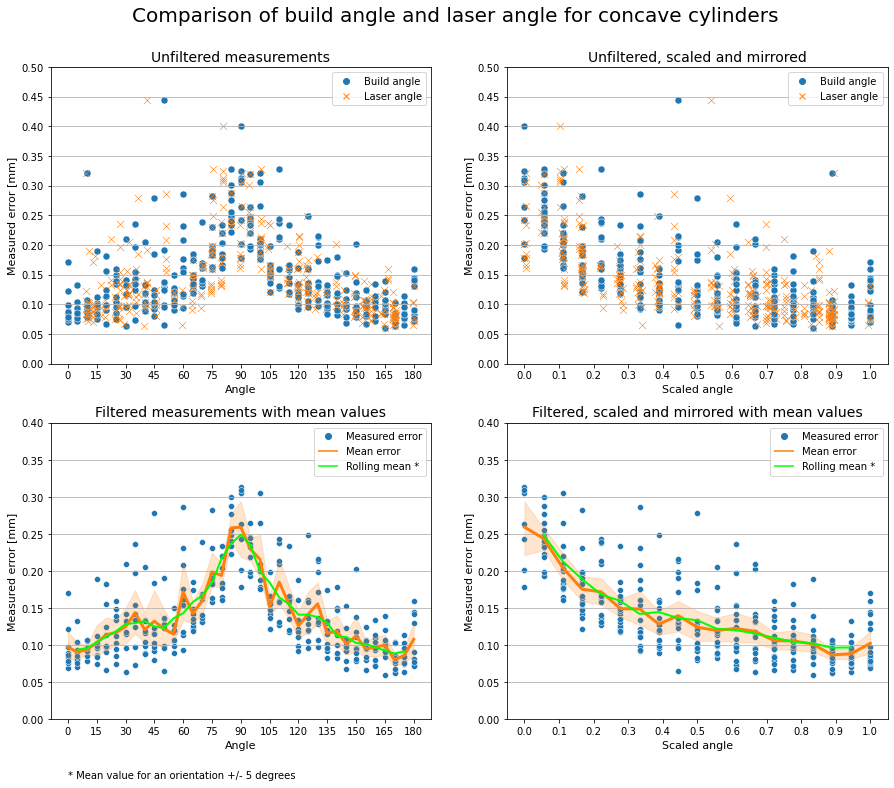

In [6]:
"""
Plot measured error for concave cylinders with respect to orientation.
Consider both build angle and laser angle.
Filter, scale and mirror about 90-degree point results to show symmetry.
Draw line-plots for mean and rolling mean.

"""
## Prepare data
# List of characteristics
chars = ['Cylindricity_Cyl_8mm_Neg',\
         'Cylindricity_Cyl_16mm-Neg',\
         'Cylindricity_Cyl_24mm_Neg']

# Retrieve the characteristics from the dictionary
dfs = pd.concat(char_dict[chars[i]] for i in range(len(chars)))

# Remove anchors from dataset
dfs = dfs[dfs['angle'] != -90]

# Add column for laser angle
dfs = func.add_laser_angle(dfs)

# Add scaled angles for build angle
dfs.insert(7, 's_b_angle', abs(dfs['angle']-90) / 90)

# Add scaled angles for laser angle
dfs.insert(7, 's_l_angle', abs(dfs['laser_angle']-90) / 90)


## Create figure
# Initialize figure as a grid of plots
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))

# Define colors
colors = ['tab:blue', 'tab:orange', 'lime']

# Define markers
symbols = ['o', 'x']

# Define marker size
size = 50

# Define transperancy
transp = 1

# Initialize list for legend creation
legend_elements = []


## Plot the unfiltered data
sns.scatterplot(ax=axs[0, 0], data=dfs, x='angle', y='error', marker=symbols[0], s=size, color=colors[0])
sns.scatterplot(ax=axs[0, 0], data=dfs, x='laser_angle', y='error', marker=symbols[1], color=colors[1], s=size, alpha=transp, legend='full')
sns.scatterplot(ax=axs[0, 1], data=dfs, x='s_b_angle', y='error', marker=symbols[0], s=size, color=colors[0])
sns.scatterplot(ax=axs[0, 1], data=dfs, x='s_l_angle', y='error', marker=symbols[1], s=size, color=colors[1], alpha=transp, legend='full')

# Define legend elements
legend_elements.append([Line2D([], [], color=colors[0], marker=symbols[0], dashes=(0, 1), label="Build angle"),\
                        Line2D([], [], color=colors[1], marker=symbols[1], dashes=(0, 1), label="Laser angle")])


##################################################################################################
###                                                                                            ###
###                                        Apply filter                                        ###
###                                                                                            ###
##################################################################################################

# Available filters
filter_types = ['std', 'quantile']

# Customizable settings
use_type = 'std'
q_size = 0.9


# Calculate the standard deviation for the entire population
std = dfs['error'].std()


## Iterate dataframe to calculate limits
for ang in dfs['s_b_angle'].unique():
    
    # Calculate limits as +/- 3 standard deviations
    if use_type == filter_types[0]:
        hi_lim = dfs[(dfs['s_b_angle'] == ang)]['error'].mean() + (3*std)
        lo_lim = dfs[(dfs['s_b_angle'] == ang)]['error'].mean() - (3*std)
    
    # Calculate limits as quantiles defined in q_size
    elif use_type == filter_types[1]:
        hi_lim = dfs[(dfs['s_b_angle'] == ang)]['error'].quantile(q_size)
        lo_lim = dfs[(dfs['s_b_angle'] == ang)]['error'].quantile(1-q_size)
        print(hi_lim)
        
## Filter results
for ang in dfs['s_b_angle'].unique():
    if ang == dfs['s_b_angle'].unique()[0]:
        df_filtered = dfs[(dfs['s_b_angle'] == ang) & (dfs['error'] < hi_lim) & (dfs['error'] > lo_lim)]
    else:
        df_filtered = pd.concat([df_filtered, dfs[(dfs['s_b_angle'] == ang) & (dfs['error'] < hi_lim) & (dfs['error'] > lo_lim)]])        

        
##################################################################################################


## Plot the filtered data
sns.scatterplot(ax=axs[1, 0], data=df_filtered, x='angle', y='error', color=colors[0])
sns.scatterplot(ax=axs[1, 1], data=df_filtered, x='s_b_angle', y='error', color=colors[0])
sns.lineplot(ax=axs[1, 0], data=df_filtered, x='angle', y='error', color=colors[1], linewidth=3)
sns.lineplot(ax=axs[1, 1], data=df_filtered, x='s_b_angle', y='error', color=colors[1], linewidth=3)


## Calculate mean values
# Create dataframe with mean error values for each angle
m_df = df_filtered[['error', 'angle']].groupby('angle').mean().reset_index()

# Compute the rolling mean for each angle +/- 1
m_df['rolling'] = m_df['error'].rolling(3).mean().shift(-1)

# Create dataframe with mean error values for each scaled angle
m_s_df = dfs[['error', 's_b_angle']].groupby('s_b_angle').mean().reset_index()

# Compute the rolling mean for each scaled angle +/- 1
m_s_df['rolling'] = m_s_df['error'].rolling(3).mean().shift(-1)

# Plot rolling mean values to second row of the figure
sns.lineplot(ax=axs[1, 0], data=m_df, x='angle', y='rolling', color=colors[2], linewidth=2)
sns.lineplot(ax=axs[1, 1], data=m_s_df, x='s_b_angle', y='rolling', color=colors[2], linewidth=2)

# Define legend elements
legend_elements.append([Line2D([], [], color=colors[0], marker='o', dashes=(0, 1), label="Measured error"),\
                        Line2D([], [], color=colors[1], dashes=(1, 0), label="Mean error"),\
                        Line2D([], [], color=colors[2], dashes=(1, 0), label="Rolling mean *")])


## Iterate over four plots to configure
for i in range(2):
    for j in range(2):
        axs[i, j].legend(handles=legend_elements[i], loc='upper right')
        axs[i, j].set_ylim(0, 0.5 if i == 0 else 0.4)
        axs[i, j].set_yticks(np.linspace(0, 0.5 if i == 0 else 0.4, 11 if i == 0 else 9))
        axs[i, j].set_xticks(np.arange(0, 181, 15) if j == 0 else np.linspace(0, 1, 11))
        axs[i, j].grid(axis='y')
        axs[i, j].set_xlabel("Angle" if j == 0 else "Scaled angle", fontsize=11)
        axs[i, j].set_ylabel("Measured error [mm]", fontsize=11)

# Set titles for all plots
axs[0, 0].set_title("Unfiltered measurements", fontsize=14)
axs[0, 1].set_title("Unfiltered, scaled and mirrored", fontsize=14)
axs[1, 0].set_title("Filtered measurements with mean values", fontsize=14)
axs[1, 1].set_title("Filtered, scaled and mirrored with mean values", fontsize=14)

# Add footnote corresponding to legend entry
axs[1, 0].text(0, -0.08, "* Mean value for an orientation +/- 5 degrees")

# Set figure title
fig.suptitle('Comparison of build angle and laser angle for concave cylinders', y=0.95, fontsize=20)


## Display plot
plt.show()

---

## Cylindricity of all cylinders

---

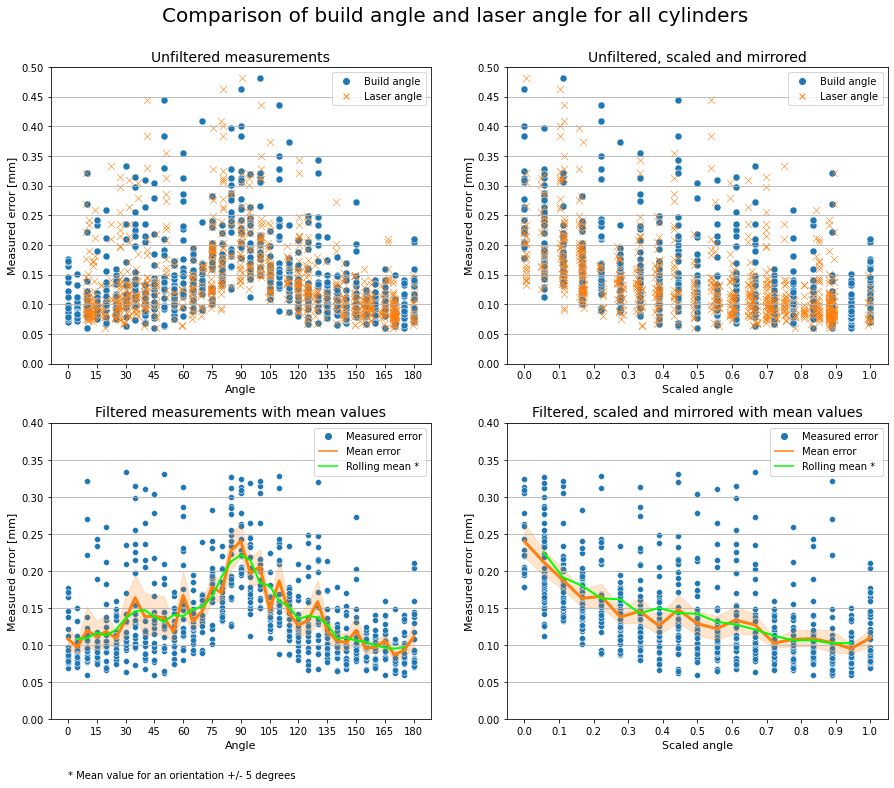

In [7]:
"""
Plot measured error for all cylinders with respect to orientation.
Consider both build angle and laser angle.
Filter, scale and mirror about 90-degree point results to show symmetry.
Draw line-plots for mean and rolling mean.

"""
## Prepare data
# List of characteristics
chars = ['Cylindricity_Cyl_4mm_Pos',\
        'Cylindricity_Cyl_8mm_Neg',\
        'Cylindricity_Cyl_8mm_Pos',\
        'Cylindricity_Cyl_16mm-Neg',\
        'Cylindricity_Cyl_16mm_Pos',\
        'Cylindricity_Cyl_24mm_Neg',\
        'Cylindricity_Cyl_24mm_Pos']

# Retrieve the characteristics from the dictionary
dfs = pd.concat(char_dict[chars[i]] for i in range(len(chars)))

# Remove anchors from dataset
dfs = dfs[dfs['angle'] != -90]

# Add column for laser angle
dfs = func.add_laser_angle(dfs)

# Add scaled angles for build angle
dfs.insert(7, 's_b_angle', abs(dfs['angle']-90) / 90)

# Add scaled angles for laser angle
dfs.insert(7, 's_l_angle', abs(dfs['laser_angle']-90) / 90)


## Create figure
# Initialize figure as a grid of plots
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))

# Define colors
colors = ['tab:blue', 'tab:orange', 'lime']

# Define markers
symbols = ['o', 'x']

# Define marker size
size = 50

# Define transperancy
transp = 1

# Initialize list for legend creation
legend_elements = []


## Plot the unfiltered data
sns.scatterplot(ax=axs[0, 0], data=dfs, x='angle', y='error', marker=symbols[0], s=size, color=colors[0])
sns.scatterplot(ax=axs[0, 0], data=dfs, x='laser_angle', y='error', marker=symbols[1], color=colors[1], s=size, alpha=transp, legend='full')
sns.scatterplot(ax=axs[0, 1], data=dfs, x='s_b_angle', y='error', marker=symbols[0], s=size, color=colors[0])
sns.scatterplot(ax=axs[0, 1], data=dfs, x='s_l_angle', y='error', marker=symbols[1], s=size, color=colors[1], alpha=transp, legend='full')

# Define legend elements
legend_elements.append([Line2D([], [], color=colors[0], marker=symbols[0], dashes=(0, 1), label="Build angle"),\
                        Line2D([], [], color=colors[1], marker=symbols[1], dashes=(0, 1), label="Laser angle")])


##################################################################################################
###                                                                                            ###
###                                        Apply filter                                        ###
###                                                                                            ###
##################################################################################################

# Available filters
filter_types = ['std', 'quantile']

# Customizable settings
use_type = 'std'
q_size = 0.9


# Calculate the standard deviation for the entire population
std = dfs['error'].std()


## Iterate dataframe to calculate limits
for ang in dfs['s_b_angle'].unique():
    
    # Calculate limits as +/- 3 standard deviations
    if use_type == filter_types[0]:
        hi_lim = dfs[(dfs['s_b_angle'] == ang)]['error'].mean() + (3*std)
        lo_lim = dfs[(dfs['s_b_angle'] == ang)]['error'].mean() - (3*std)
    
    # Calculate limits as quantiles defined in q_size
    elif use_type == filter_types[1]:
        hi_lim = dfs[(dfs['s_b_angle'] == ang)]['error'].quantile(q_size)
        lo_lim = dfs[(dfs['s_b_angle'] == ang)]['error'].quantile(1-q_size)
        print(hi_lim)
        
## Filter results
for ang in dfs['s_b_angle'].unique():
    if ang == dfs['s_b_angle'].unique()[0]:
        df_filtered = dfs[(dfs['s_b_angle'] == ang) & (dfs['error'] < hi_lim) & (dfs['error'] > lo_lim)]
    else:
        df_filtered = pd.concat([df_filtered, dfs[(dfs['s_b_angle'] == ang) & (dfs['error'] < hi_lim) & (dfs['error'] > lo_lim)]])        

        
##################################################################################################


## Plot the filtered data
sns.scatterplot(ax=axs[1, 0], data=df_filtered, x='angle', y='error', color=colors[0])
sns.scatterplot(ax=axs[1, 1], data=df_filtered, x='s_b_angle', y='error', color=colors[0])
sns.lineplot(ax=axs[1, 0], data=df_filtered, x='angle', y='error', color=colors[1], linewidth=3)
sns.lineplot(ax=axs[1, 1], data=df_filtered, x='s_b_angle', y='error', color=colors[1], linewidth=3)


## Calculate mean values
# Create dataframe with mean error values for each angle
m_df = df_filtered[['error', 'angle']].groupby('angle').mean().reset_index()

# Compute the rolling mean for each angle +/- 1
m_df['rolling'] = m_df['error'].rolling(3).mean().shift(-1)

# Create dataframe with mean error values for each scaled angle
m_s_df = dfs[['error', 's_b_angle']].groupby('s_b_angle').mean().reset_index()

# Compute the rolling mean for each scaled angle +/- 1
m_s_df['rolling'] = m_s_df['error'].rolling(3).mean().shift(-1)

# Plot rolling mean values to second row of the figure
sns.lineplot(ax=axs[1, 0], data=m_df, x='angle', y='rolling', color=colors[2], linewidth=2)
sns.lineplot(ax=axs[1, 1], data=m_s_df, x='s_b_angle', y='rolling', color=colors[2], linewidth=2)

# Define legend elements
legend_elements.append([Line2D([], [], color=colors[0], marker='o', dashes=(0, 1), label="Measured error"),\
                        Line2D([], [], color=colors[1], dashes=(1, 0), label="Mean error"),\
                        Line2D([], [], color=colors[2], dashes=(1, 0), label="Rolling mean *")])


## Iterate over four plots to configure
for i in range(2):
    for j in range(2):
        axs[i, j].legend(handles=legend_elements[i], loc='upper right')
        axs[i, j].set_ylim(0, 0.5 if i == 0 else 0.4)
        axs[i, j].set_yticks(np.linspace(0, 0.5 if i == 0 else 0.4, 11 if i == 0 else 9))
        axs[i, j].set_xticks(np.arange(0, 181, 15) if j == 0 else np.linspace(0, 1, 11))
        axs[i, j].grid(axis='y')
        axs[i, j].set_xlabel("Angle" if j == 0 else "Scaled angle", fontsize=11)
        axs[i, j].set_ylabel("Measured error [mm]", fontsize=11)

# Set titles for all plots
axs[0, 0].set_title("Unfiltered measurements", fontsize=14)
axs[0, 1].set_title("Unfiltered, scaled and mirrored", fontsize=14)
axs[1, 0].set_title("Filtered measurements with mean values", fontsize=14)
axs[1, 1].set_title("Filtered, scaled and mirrored with mean values", fontsize=14)

# Add footnote corresponding to legend entry
axs[1, 0].text(0, -0.08, "* Mean value for an orientation +/- 5 degrees")

# Set figure title
fig.suptitle('Comparison of build angle and laser angle for all cylinders', y=0.95, fontsize=20)


## Display plot
plt.show()

---

## Flatness of planes

---

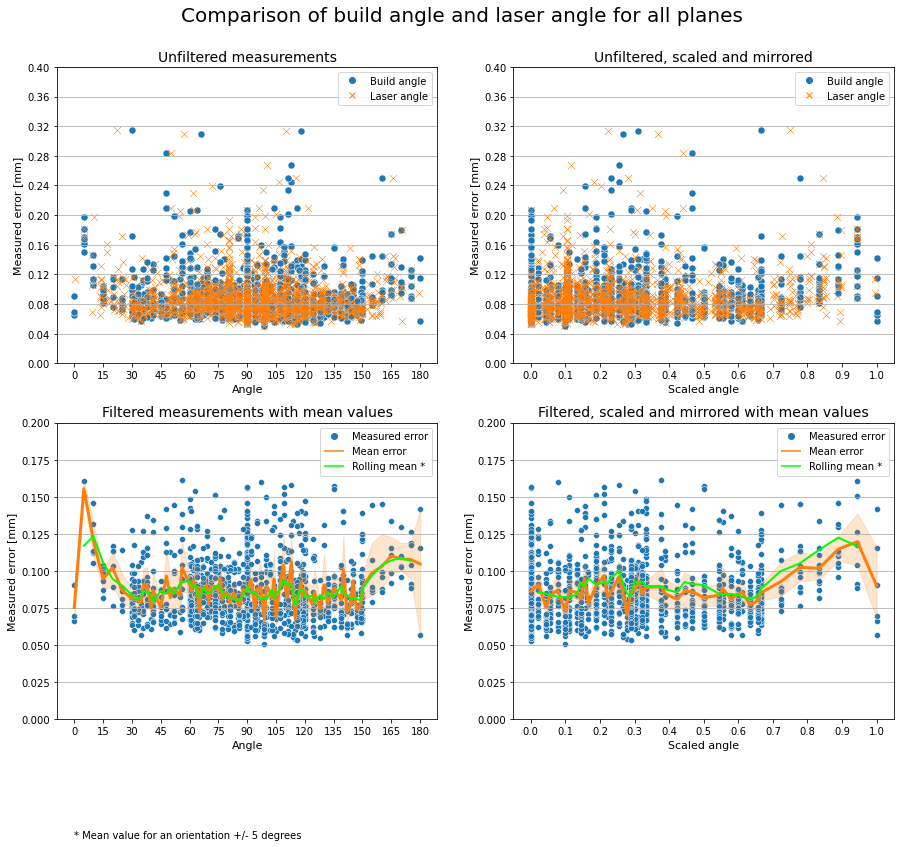

In [8]:
"""
Plot measured error for all planes with respect to orientation.
Consider both build angle and laser angle.
Filter, scale and mirror about 90-degree point results to show symmetry.
Draw line-plots for mean and rolling mean.

"""
## Prepare data
# List of characteristics
chars = ['Flatness_HX1_Plane1', # 0  / 0
         'Flatness_HX1_Plane2', # 1  / 60
         'Flatness_HX1_Plane3', # 2  / 120
         'Flatness_HX1_Plane4', # 3  / 180
         'Flatness_HX1_Plane5', # 4  / 240
         'Flatness_HX1_Plane6', # 5  / 300
         'Flatness_HX2_Plane1', # 6  / 30
         'Flatness_HX2_Plane2', # 7  / 90
         'Flatness_HX2_Plane3', # 8  / 150
         'Flatness_HX2_Plane4', # 9  / 210
         'Flatness_HX2_Plane5', # 10 / 270
         'Flatness_HX2_Plane6'] # 11 / 330

# Retrieve the characteristics from the dictionary
char_list = [char_dict[chars[i]] for i in range(len(chars))]


##################################################################################################
###
### Calculate actual build angle of planes
###

# Initiate list of characteristic vectors
char_vecs = []
f_vecs = []
angs = []
l_angs = []

# Go thorugh the characteristics
for char, i in zip(char_list, range(len(chars))):
    
    # Calculate the feature vector and include in vector list
    char_vecs.extend([func.rotate_vector(np.array([0, -1, 0]), c=i*60 if i < 6 else ((i-6)*60) + 30)] * len(char))
    
    for j in range(len(char)):
        f_vecs.append(func.rotate_vector(char_vecs[(i*len(char)) + j], a=char.iloc[j]['angle']))
        angs.append(func.calc_angle(f_vecs[(i*len(char)) + j], [0, 0, 1]))
        l_angs.append(func.calc_laser_angle(x=char.iloc[j]['center_x'], y=char.iloc[j]['center_y'], feature_vector=f_vecs[(i*len(char)) + j]))
    
# Concatinate the dataframes into one
dfs = pd.concat(char_list)

# Add the characteristic vectors as a separate column
dfs['char_vector'] = char_vecs

# Add feature vectors as a separate column
dfs['f_vector'] = f_vecs

# Add feature angles as a separate column
dfs['f_angle'] = angs

# Add laser angles as a separate column
dfs['laser_angle'] = l_angs

# Remove anchors from dataset
dfs = dfs[dfs['angle'] != -90]

dfs['f_angle'] = dfs['f_angle'].round()


##################################################################################################

# Add scaled angles for build angle
dfs.insert(7, 's_b_angle', abs(dfs['f_angle']-90) / 90)

# Add scaled angles for laser angle
dfs.insert(7, 's_l_angle', abs(dfs['laser_angle']-90) / 90)


## Create figure
# Initialize figure as a grid of plots
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))

# Define colors
colors = ['tab:blue', 'tab:orange', 'lime']

# Define markers
symbols = ['o', 'x']

# Define marker size
size = 50

# Define transperancy
transp = 1

# Initialize list for legend creation
legend_elements = []


## Plot the unfiltered data
sns.scatterplot(ax=axs[0, 0], data=dfs, x='f_angle', y='error', marker=symbols[0], s=size, color=colors[0])
sns.scatterplot(ax=axs[0, 0], data=dfs, x='laser_angle', y='error', marker=symbols[1], color=colors[1], s=size, alpha=transp, legend='full')
sns.scatterplot(ax=axs[0, 1], data=dfs, x='s_b_angle', y='error', marker=symbols[0], s=size, color=colors[0])
sns.scatterplot(ax=axs[0, 1], data=dfs, x='s_l_angle', y='error', marker=symbols[1], s=size, color=colors[1], alpha=transp, legend='full')

# Define legend elements
legend_elements.append([Line2D([], [], color=colors[0], marker=symbols[0], dashes=(0, 1), label="Build angle"),\
                        Line2D([], [], color=colors[1], marker=symbols[1], dashes=(0, 1), label="Laser angle")])


##################################################################################################
###                                                                                            ###
###                                        Apply filter                                        ###
###                                                                                            ###
##################################################################################################

# Available filters
filter_types = ['std', 'quantile']

# Customizable settings
use_type = 'std'
q_size = 0.9


# Calculate the standard deviation for the entire population
std = dfs['error'].std()


## Iterate dataframe to calculate limits
for ang in dfs['s_b_angle'].unique():
    
    # Calculate limits as +/- 3 standard deviations
    if use_type == filter_types[0]:
        hi_lim = dfs[(dfs['s_b_angle'] == ang)]['error'].mean() + (3*std)
        lo_lim = dfs[(dfs['s_b_angle'] == ang)]['error'].mean() - (3*std)
    
    # Calculate limits as quantiles defined in q_size
    elif use_type == filter_types[1]:
        hi_lim = dfs[(dfs['s_b_angle'] == ang)]['error'].quantile(q_size)
        lo_lim = dfs[(dfs['s_b_angle'] == ang)]['error'].quantile(1-q_size)
        print(hi_lim)
        
## Filter results
for ang in dfs['s_b_angle'].unique():
    if ang == dfs['s_b_angle'].unique()[0]:
        df_filtered = dfs[(dfs['s_b_angle'] == ang) & (dfs['error'] < hi_lim) & (dfs['error'] > lo_lim)]
    else:
        df_filtered = pd.concat([df_filtered, dfs[(dfs['s_b_angle'] == ang) & (dfs['error'] < hi_lim) & (dfs['error'] > lo_lim)]])        

        
##################################################################################################


## Plot the filtered data
sns.scatterplot(ax=axs[1, 0], data=df_filtered, x='f_angle', y='error', color=colors[0])
sns.scatterplot(ax=axs[1, 1], data=df_filtered, x='s_b_angle', y='error', color=colors[0])
sns.lineplot(ax=axs[1, 0], data=df_filtered, x='f_angle', y='error', color=colors[1], linewidth=3)
sns.lineplot(ax=axs[1, 1], data=df_filtered, x='s_b_angle', y='error', color=colors[1], linewidth=3)


## Calculate mean values
# Create dataframe with mean error values for each angle
m_df = df_filtered[['error', 'f_angle']].groupby('f_angle').mean().reset_index()

# Compute the rolling mean for each angle +/- 1
m_df['rolling'] = m_df['error'].rolling(3).mean().shift(-1)

# Create dataframe with mean error values for each scaled angle
m_s_df = dfs[['error', 's_b_angle']].groupby('s_b_angle').mean().reset_index()

# Compute the rolling mean for each scaled angle +/- 1
m_s_df['rolling'] = m_s_df['error'].rolling(3).mean().shift(-1)

# Plot rolling mean values to second row of the figure
sns.lineplot(ax=axs[1, 0], data=m_df, x='f_angle', y='rolling', color=colors[2], linewidth=2)
sns.lineplot(ax=axs[1, 1], data=m_s_df, x='s_b_angle', y='rolling', color=colors[2], linewidth=2)

# Define legend elements
legend_elements.append([Line2D([], [], color=colors[0], marker='o', dashes=(0, 1), label="Measured error"),\
                        Line2D([], [], color=colors[1], dashes=(1, 0), label="Mean error"),\
                        Line2D([], [], color=colors[2], dashes=(1, 0), label="Rolling mean *")])


## Iterate over four plots to configure
for i in range(2):
    for j in range(2):
        axs[i, j].legend(handles=legend_elements[i], loc='upper right')
        axs[i, j].set_ylim(0, math.ceil(dfs['error'].max()*10)/10 if i == 0 else math.ceil(m_df['error'].max()*10)/10)
        axs[i, j].set_yticks(np.linspace(0, math.ceil(dfs['error'].max()*10)/10 if i == 0 else math.ceil(m_df['error'].max()*10)/10, 11 if i == 0 else 9))
        axs[i, j].set_xticks(np.arange(0, 181, 15) if j == 0 else np.linspace(0, 1, 11))
        axs[i, j].grid(axis='y')
        axs[i, j].set_xlabel("Angle" if j == 0 else "Scaled angle", fontsize=11)
        axs[i, j].set_ylabel("Measured error [mm]", fontsize=11)

# Set titles for all plots
axs[0, 0].set_title("Unfiltered measurements", fontsize=14)
axs[0, 1].set_title("Unfiltered, scaled and mirrored", fontsize=14)
axs[1, 0].set_title("Filtered measurements with mean values", fontsize=14)
axs[1, 1].set_title("Filtered, scaled and mirrored with mean values", fontsize=14)

# Add footnote corresponding to legend entry
axs[1, 0].text(0, -0.08, "* Mean value for an orientation +/- 5 degrees")

# Set figure title
fig.suptitle('Comparison of build angle and laser angle for all planes', y=0.95, fontsize=20)


## Display plot
plt.show()